## Covariance Estimation, Shrinkage and Volatility Prediction

This short analysis intends to exemplify and investigate the effects of shrinkage on portfolio volatility and prediction thereof. Recall the definition of covariance:

$$ Cov(X,Y) = E[(X - E[Y])(Y - E[Y])] $$

where $X$ and $Y$ are random variables (e.g. stock returns). The covariance matrix is then defined as the pairwise covariance for any set of random variables $X_i$ and $Y_j$ for $i,j= 1...n$ and denoted as $\Sigma$. For any given sample covariance matrix $S$ and mean variance $\mu$, shrinkage of a covariance matrix is mathematically defined as 

$$ (1 - \delta)S + \delta \mu 1$$

for a shrinkage constant $\delta$ between 0 and 1. $1$ is a matrix of ones such that $\mu 1$ becomes a matrix of the mean variance. This leaves us ready for looking at some data.

## Data
The data included in the optimization procedure are monthly series on asset prices from which monthly returns are computed for all included assets. The assets included in the optimization are global indices: S\&P500 (U.S. large cap), Russel 2000 (U.S. small cap), FTSE U.S. Real Estate Investment Trust (REIT), MSCI EAFE (developed market outside the U.S. and Canada), MSCI Emerging Markets, BofA Merrill Lynch U.S.-Government Bond (all maturities), Barclays U.S. Corporate HY, Gold, and S\&P GSCI (diversified commodity index). The price data stretches from January 1992 to December 2013 with 189 observations in total.

In [1]:
from scipy import io
import numpy as np
import pandas as pd
import datetime as dt

mvo_data = io.loadmat('data/mvo_data.mat')
headers = mvo_data['Headers']
returns = np.array(mvo_data['Ret'])
#data = pd.DataFrame(data=returns,index=returns[1:,])
#mvo_data.keys()
#type(mvo_data['Ret'][0][0][0][0]), mvo_data['Ret'][0][0][0][0].shape, mvo_data['Ret'][0][0][0][1], headers[0][0][0], mvo_data['Ret'][0][0][1][1]
columns = [item[0][0] for item in headers]
data = [[row.flat[0] for row in line] for line in mvo_data['Ret'][0][0][0]]
index = [dt.datetime.fromordinal(item[0]).strftime('%Y-%m-%d') for item in mvo_data['Ret'][0][0][1] ]
df = pd.DataFrame(data=data,index=index, columns=columns)
df['DTE'] = df.index.map(lambda x: x[0:7] )
df = df.set_index('DTE')
df.head()

,S&P500 TR,Russell 2000 TR,FTSE REIT TR,MSCI EAFE TR,MSCI Emerging Markets TR,Barclays US Government TR,Barclays US Corporate High Yield TR,Gold TR,SP GSCI TR,US TBILL TR
DTE,,,,,,,,,,
1993-01,-0.018635,0.081027,0.048700,-0.021341,0.115766,-0.015568,0.035225,0.005060,0.027491,0.003486
1993-04,-0.006749,-0.005664,-0.040124,-0.099452,0.079766,-0.001961,0.037378,-0.040538,0.000087,0.006252
1993-05,0.029361,-0.035034,-0.003551,0.004704,-0.006946,0.006299,0.003798,-0.017764,0.029964,0.003847
1993-07,-0.010048,-0.034624,0.030033,0.016361,-0.102430,0.033044,0.023659,0.015103,0.021207,0.006386
1993-08,0.040852,0.034795,0.043447,-0.025593,0.010874,0.025201,0.015097,0.037746,-0.013935,0.003417


Looking at the data we can see that some variables show signs of high pairwise correlation, while others do not.

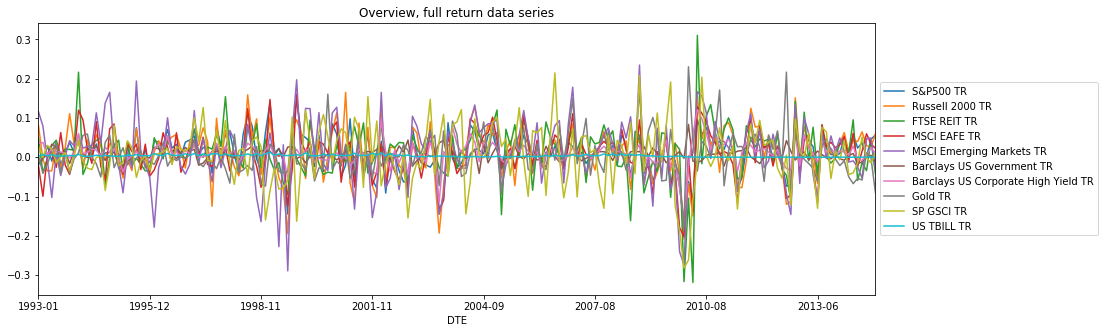

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plotdata=df
plt.figure()
plotdata.plot(figsize=(15,5), title="Overview, full return data series")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [3]:
corr_matrix = df.corr(method='pearson')
cov_matrix = df.cov()
corr_matrix

,S&P500 TR,Russell 2000 TR,FTSE REIT TR,MSCI EAFE TR,MSCI Emerging Markets TR,Barclays US Government TR,Barclays US Corporate High Yield TR,Gold TR,SP GSCI TR,US TBILL TR
S&P500 TR,1.000000,0.791352,0.534286,0.779702,0.660316,-0.153906,0.616575,0.002496,0.158581,0.129287
Russell 2000 TR,0.791352,1.000000,0.603087,0.691324,0.663276,-0.224422,0.618267,0.097540,0.226216,0.002848
FTSE REIT TR,0.534286,0.603087,1.000000,0.503986,0.375841,0.060991,0.558520,0.079118,0.211708,0.044277
MSCI EAFE TR,0.779702,0.691324,0.503986,1.000000,0.722860,-0.129269,0.609080,0.198384,0.292656,0.048198
MSCI Emerging Markets TR,0.660316,0.663276,0.375841,0.722860,1.000000,-0.177886,0.636969,0.288508,0.285591,-0.003717
Barclays US Government TR,-0.153906,-0.224422,0.060991,-0.129269,-0.177886,1.000000,-0.016405,0.259888,-0.140001,0.221968
Barclays US Corporate High Yield TR,0.616575,0.618267,0.558520,0.609080,0.636969,-0.016405,1.000000,0.219235,0.264991,-0.007259
Gold TR,0.002496,0.097540,0.079118,0.198384,0.288508,0.259888,0.219235,1.000000,0.260174,-0.105375
SP GSCI TR,0.158581,0.226216,0.211708,0.292656,0.285591,-0.140001,0.264991,0.260174,1.000000,0.026642
US TBILL TR,0.129287,0.002848,0.044277,0.048198,-0.003717,0.221968,-0.007259,-0.105375,0.026642,1.000000


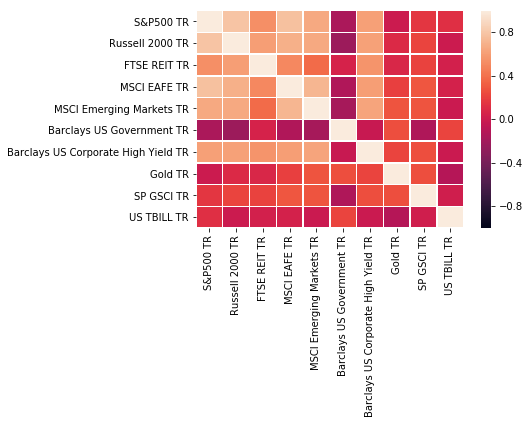

In [4]:
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5)

## Volatility Prediction and Shrinkage

Now, lets look at how well the volatility is predicted by the standard covariance matrix and one shrunk using Ledoit-Wolf estimation. First, check the Mean-Squared Error (MSE) difference between standard covariance- vs. Ledoit-Wolf (shrunk) covariance estimation.

In [5]:
#Calculate sample covariance- and ledoit-estimated matrices
from sklearn.covariance import ledoit_wolf
covdata_insample = df.iloc[0:150,:] #in sample data for estimation
covdata_outsample = df.iloc[151:np.size(df.iloc[:,1]),:] #out of sample data for prediction analysis
cov_in = covdata_insample.cov().values
cov_out = covdata_outsample.cov().values
ledoit_in = ledoit_wolf(covdata_insample)[0]
ledoit_out = ledoit_wolf(covdata_outsample)[0]

In [6]:
#Compare standard errors
cov_mse = np.mean(sum(abs(np.subtract(cov_in, cov_out))))
ledoit_mse = np.mean(sum(abs(np.subtract(ledoit_in, ledoit_out))))
'MSE difference between Ledoit-Wolf and Cov = {0:.2f} %'.format((ledoit_mse/cov_mse-1)*100)


'MSE difference between Ledoit-Wolf and Cov = -5.04 %'

As expected, the Ledoit-Wolf estimator yields a lower MSE than using standard covariance. Check if this holds in a bit more generalized setting

In [7]:
#Simulate N normal distributed random returns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
N = 100000
mu = 0.5
vol_scale = 1
ccoef = 0

X1 = mu + vol_scale*np.random.normal(0,1,N)
X2 = ccoef*X1 + np.random.normal(0,1,N)
X3 = ccoef*X1*2 + np.random.normal(0,1,N)
X1_out = mu + vol_scale*np.random.normal(0,1,N)
X2_out = ccoef*X1_out + np.random.normal(0,1,N)
X3_out = ccoef*X1*2 + np.random.normal(0,1,N)
sample_in = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})
sample_out = pd.DataFrame({'X1':X1_out, 'X2':X2_out, 'X3':X3_out})
sample_in.corr()


,X1,X2,X3
X1,1.000000,-0.005976,0.003853
X2,-0.005976,1.000000,0.000799
X3,0.003853,0.000799,1.000000


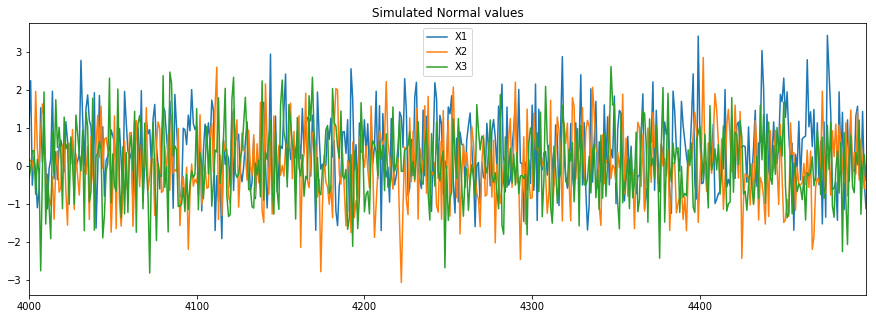

In [8]:
#Plot data
plotdata=sample_in.iloc[4000:4500,:]
plt.figure()
plotdata.plot(figsize=(15,5), title="Simulated Normal values")

In [9]:
#Compare covariance estimators
from sklearn.covariance import ledoit_wolf
cov_sample = sample_in.cov().values
cov_out = sample_out.cov().values
ledoit_sample = ledoit_wolf(sample_in)[0]
ledoit_out = ledoit_wolf(sample_out)[0]
cov_mse = np.mean(sum(abs(np.subtract(cov_sample, cov_out))))
ledoit_mse = np.mean(sum(abs(np.subtract(ledoit_sample, ledoit_out))))
'MSE difference between Ledoit-Wolf and Cov = {0:.2f} %'.format((ledoit_mse/cov_mse-1)*100)

'MSE difference between Ledoit-Wolf and Cov = 20.78 %'

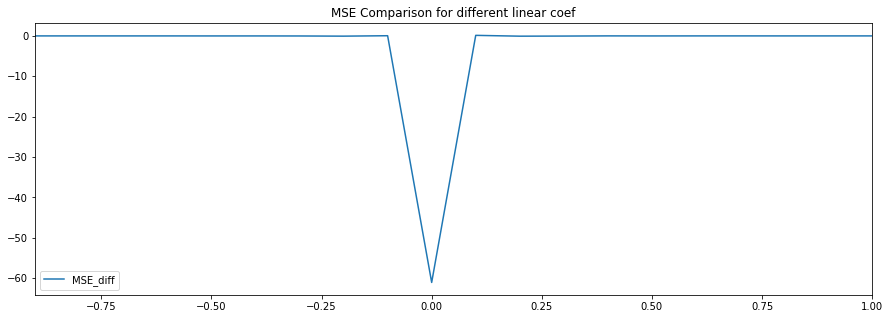

In [10]:
#Simulate several trials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
N = 100000
mu = 0.5
vol_scale = 1
ccoef = 0

def compare_mse(N,mu,vol_scale,ccoef):
    X1 = mu + vol_scale*np.random.normal(0,1,N)
    X2 = ccoef*X1 + np.random.normal(0,1,N)
    X3 = ccoef*X1*2 + np.random.normal(0,1,N)
    X1_out = mu + vol_scale*np.random.normal(0,1,N)
    X2_out = ccoef*X1_out + np.random.normal(0,1,N)
    X3_out = ccoef*X1*2 + np.random.normal(0,1,N)
    sample_in = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})
    sample_out = pd.DataFrame({'X1':X1_out, 'X2':X2_out, 'X3':X3_out})
    cov_sample = sample_in.cov().values
    cov_out = sample_out.cov().values
    ledoit_sample = ledoit_wolf(sample_in)[0]
    ledoit_out = ledoit_wolf(sample_out)[0]
    cov_mse = np.mean(sum(abs(np.subtract(cov_sample, cov_out))))
    ledoit_mse = np.mean(sum(abs(np.subtract(ledoit_sample, ledoit_out))))
    return (ledoit_mse/cov_mse-1)*100

mse_diff = {}
for i in range(1,21):
    coef = -1+i*0.1
    mse_diff[coef] =compare_mse(N,mu,vol_scale,coef)
sample_diff = pd.DataFrame({'MSE_diff':mse_diff})
plotdata=sample_diff
plt.figure()
plotdata.plot(figsize=(15,5), title="MSE Comparison for different linear coef")

Now, compare two mean-variance optimization scenarios where 1) is using standard covariance, and 2) is using a shrunk covariance matrix. Compare the predicted and realized volatility of these two portfolios on the sample data. 

In [40]:
#Portfolio optimization under constraints
from scipy.optimize import minimize
import numpy as np

#utility function
def utility_simple(x, mu_vec, cov_matrix):
    eret = np.dot(x,mu_vec)
    evol = x@cov_matrix@x
    return -(eret-evol/2)

def max_utility_simple(mu_vec, cov_matrix, w_a, w_b, w0):
    args = (mu_vec, cov_matrix)
    w_constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    w_bound = (w_a,w_b)
    w_bounds = tuple(w_bound for asset in range(num_assets))
    result = minimize(utility_simple, x0=w0, args=args,
                        method='SLSQP', bounds=w_bounds, constraints=w_constraints)
    return (-1*result.fun, result.x)

#Re-Calculate sample covariance- and ledoit-estimated matrices
from sklearn.covariance import ledoit_wolf
covdata_insample = df.iloc[0:150,:] #in sample data for estimation
covdata_outsample = df.iloc[151:np.size(df.iloc[:,1]),:] #out of sample data for prediction analysis
cov_in = covdata_insample.cov().values
cov_out = covdata_outsample.cov().values
ledoit_in = ledoit_wolf(covdata_insample)[0]
ledoit_out = ledoit_wolf(covdata_outsample)[0]

mu_vec = np.mean(covdata_insample) #expected returns for MPT
num_assets = len(mu_vec)
w0 = num_assets*[1./num_assets,]
opt1 = max_utility_simple(mu_vec,cov_in,0.0,0.3, w0)
opt2 = max_utility_simple(mu_vec,ledoit_in,0.0,0.3, w0)

#Portfolio weights
w1 = opt1[1]
w2 = opt2[1]
w1-w2 #difference is very small

array([ -4.32953197e-03,  -7.25682109e-03,   0.00000000e+00,
         2.38524478e-17,   0.00000000e+00,   9.70381745e-03,
         1.88253560e-03,   0.00000000e+00,   2.34187669e-17,
         0.00000000e+00])

Calculate realized returns and volatility on the in- and out of data separately

In [55]:
#Get data
ret_in = {
    'standard_cov':covdata_insample@w1
    ,'ledoit_cov':covdata_insample@w2
}
ret_out ={
    'standard_cov':covdata_outsample@w1
    ,'ledoit_cov':covdata_outsample@w2
}
diff_in = {
    'standard-ledoit':covdata_insample@w1 - covdata_insample@w2
}
diff_out = {
    'standard-ledoit':covdata_outsample@w1 - covdata_outsample@w2
}
ret_in_df = pd.DataFrame(data=ret_in)
ret_out_df = pd.DataFrame(data=ret_out)
diff_in_df = pd.DataFrame(data=diff_in)
diff_out_df = pd.DataFrame(data=diff_out)

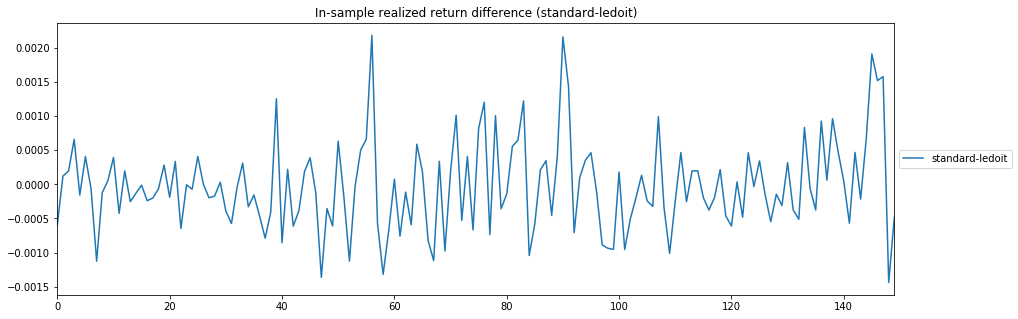

In [56]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plotdata=diff_in_df
plt.figure()
plotdata.plot(figsize=(15,5), title="In-sample realized return difference (standard-ledoit)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

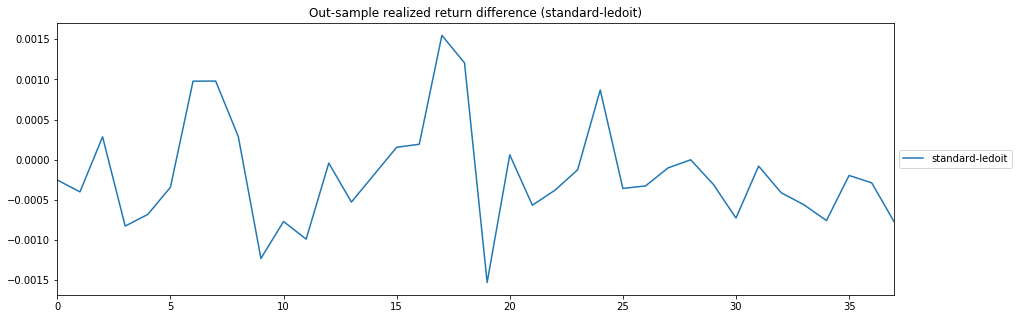

In [57]:
#Out sample
plotdata=diff_out_df
plt.figure()
plotdata.plot(figsize=(15,5), title="Out-sample realized return difference (standard-ledoit)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [58]:
#Realized volatility
ret_out_df.std()

ledoit_cov      0.044680
standard_cov    0.044166
dtype: float64

In [59]:
ret_in_df.std()

ledoit_cov      0.051893
standard_cov    0.051349
dtype: float64